In [1]:
import numpy as np
from scipy import linalg as la
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

In [2]:
FT_SIZE = 14;
plt.rc('font', size=FT_SIZE)
plt.rc('xtick',labelsize=FT_SIZE)
plt.rc('ytick',labelsize=FT_SIZE)

# MODEL: Hubbard-Mean-Field (NN & NNN) on 2D square lattice, periodic B.C., zero spin domain S_z = (nup-ndn)/2 = 0. 
# Assume up and down electrons behave the same way - no spin coupling Zeeman term
# Assume all numbers are real

In [3]:
def makeHpMatrix(Nx,Ny,t,tp,mu,density,sigma):
    '''Generate N-by-N H^+ matrix for 2D square Nx-by-Ny lattice, periodic bdy conditions.
    Args:
        t = NN hopping strength
        tp = NNN hopping stength
        mu = Chemical potential
        Nx, Ny = Lattice dimensions
        density = (N,) array of total electron density (up + dn)
        sigma = (N,) array of z spin (nup - ndn)
    Returns:
        A shape (N,N) float numpy array, N = Nx*Ny. '''

    # Initialize vectors of row and column indices, matrix data
    i,j = np.empty(0,dtype=int), np.empty(0,dtype=int)
    data = np.empty(0,dtype=float);
    
    #Look at each lattice pt, find nearest neighbors
    for y in range(Ny):
        for x in range(Nx):
            #total index n
            n = x + Nx*y;
            #neighbors, with periodic B.C.
            neighbors = [((x+1) % Nx,y),((x-1) % Nx,y),(x,(y+1) % Ny),(x,(y-1) % Ny)]
            next_neighbors = [((x+1) % Nx,(y+1) % Ny),((x-1) % Nx,(y+1) % Ny),
                              ((x+1) % Nx,(y-1) % Ny),((x-1) % Nx,(y-1) % Ny)]
            #get total indices of nearest neighbors
            for pt in neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-t)*np.ones(len(neighbors),dtype=float))
            #get total indices of next-nearest neighbors
            for pt in next_neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-tp)*np.ones(len(next_neighbors),dtype=float))
            #everything stays in n-th column
            j = np.append(j,n*np.ones(len(neighbors)+len(next_neighbors),dtype=int))
            
            #chemical potential contribes only to diagonal elements
            #extra term from mean field
            i = np.append(i,n);
            j = np.append(j,n);
            data = np.append(data,-mu + 0.5*U*(density[n]-sigma[n]))
    
    #Construction
    matrix = coo_matrix((data, (i,j)),shape = (Nx*Ny,Nx*Ny))
    return matrix

In [4]:
def makeHmMatrix(Nx,Ny,t,tp,mu,density,sigma):
    '''Generate H^- matrix for 2D square Nx-by-Ny lattice, periodic bdy conditions.
    Args:
        t = NN hopping strength
        tp = NNN hopping stength
        mu = Chemical potential
        Nx, Ny = Lattice dimensions
        density = (N,) array of total electron density (up + dn)
        sigma = (N,) array of z spin (nup - ndn)
    Returns:
        A shape (N,N) float numpy array, N = Nx*Ny. '''

    # Initialize vectors of row and column indices, matrix data
    i,j = np.empty(0,dtype=int), np.empty(0,dtype=int)
    data = np.empty(0,dtype=float);
    
    #Look at each lattice pt, find nearest neighbors
    for y in range(Ny):
        for x in range(Nx):
            #total index n
            n = x + Nx*y;
            #neighbors, with periodic B.C.
            neighbors = [((x+1) % Nx,y),((x-1) % Nx,y),(x,(y+1) % Ny),(x,(y-1) % Ny)]
            next_neighbors = [((x+1) % Nx,(y+1) % Ny),((x-1) % Nx,(y+1) % Ny),
                              ((x+1) % Nx,(y-1) % Ny),((x-1) % Nx,(y-1) % Ny)]
            #get total indices of nearest neighbors
            for pt in neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-t)*np.ones(len(neighbors),dtype=float))
            #get total indices of next-nearest neighbors
            for pt in next_neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-tp)*np.ones(len(next_neighbors),dtype=float))
            #everything stays in n-th column
            j = np.append(j,n*np.ones(len(neighbors)+len(next_neighbors),dtype=int))
            
            #chemical potential contribes only to diagonal elements
            #extra term from mean field
            i = np.append(i,n);
            j = np.append(j,n);
            data = np.append(data,-mu + 0.5*U*(density[n]+sigma[n]))
    
    #Construction
    matrix = coo_matrix((data, (i,j)),shape = (Nx*Ny,Nx*Ny))
    return matrix

In [5]:
def initDeltaMatrix(Nx,Ny,Vd):
    '''Initialize Delta matrix
    Args:
        Nx, Ny: dimensions of Lattice
        Vd: attractive pairing interaction strength
    
    Returns:
        A shape (N,N) float numpy array, N = Nx*Ny.
    '''
    # Initialize vectors of row and column indices, matrix data
    i,j = np.empty(0,dtype=int), np.empty(0,dtype=int);
    data = np.empty(0,dtype=float);
    
    #Look at each lattice pt, find nearest neighbors
    for y in range(Ny):
        for x in range(Nx):
            #total index n
            n = x + Nx*y;
            #neighbors, with periodic B.C.
            neighbors = [((x+1) % Nx,y),((x-1) % Nx,y),(x,(y+1) % Ny),(x,(y-1) % Ny)]
            #get total indices of nearest neighbors
            for pt in neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-Vd)*np.ones(len(neighbors),dtype=float))
            #get total indices of next-nearest neighbors
            #everything stays in n-th column
            j = np.append(j,n*np.ones(len(neighbors),dtype=int))
    
    #Construction
    return coo_matrix((data, (i,j)),shape = (Nx*Ny,Nx*Ny)).toarray(),i,j

In [6]:
def Build_H(Delta,n,sigma):
    '''Create 2N by 2N matrix to diagonalize.
    Args:
        Delta: (N,N) np array
        n: (N,) np array
        sigma: (N,) np array
        
    Returns:
        (2N,2N) np array
    '''
    H = np.empty((2*N,2*N),dtype=float)
    #(0,0) block
    Hp = makeHpMatrix(Nx,Ny,t,tp,mu,n,sigma);
    #(1,1) block
    Hm = makeHmMatrix(Nx,Ny,t,tp,mu,n,sigma);
    
    #row1 = hstack((Hp,Delta));
    #row2 = hstack((Delta.conj(),-Hm.conj()))
    #H = vstack((row1,row2))
    
    #set blocks of total hamiltonian matrix
    H[:N,:N] = Hp.toarray()
    H[N:,N:] = -Hm.toarray().conj();
    H[:N,N:] = Delta;
    H[N:,:N] = Delta.conj()
    return H

In [7]:
def Fermi_Dist(E,beta):
    '''Fermion occupation function'''
    return 1/(1+np.exp(beta*E))

In [8]:
def Make_Delta_ij(Vd, E, Umat, Vmat, beta):
    '''Eq A.12 update Delta matrix based on current eigenvalues
    But this always just ends up being zero?
    Args:
        Vd: attractive pairing interaction strength
        E: (2N,) array
        Umat: (N,2N) array, each col is an eigenvec u
        Vmat: (N,2N) array, each col is an eigenvec v
        beta: inverse temperature
    
    '''
    #assert 2*N == E.shape[0] #use all energies
    #assert Umat.shape == Vmat.shape == (N,2*N) #
    
    energy_term = np.tanh(0.5*beta*E)
    accum = np.zeros((N,N),dtype=float);
    for n in range(E.shape[0]):
        accum += (np.outer(Umat[:,n],Vmat[:,n]) +\
                    np.outer(Vmat[:,n],Umat[:,n])) * energy_term[n] * Vd/4
    
    #print(energy_term)
    #delta = np.zeros((N,N))
    #for pt in range(len(ilist)):
        #i = ilist[pt]
        #j = jlist[pt]
        #for n in range(2*N):
            #print(Umat[i,n]*Vmat[j,n]+ Umat[j,n]*Vmat[i,n])
            #delta[i,j] += (Umat[i,n]*Vmat[j,n]+ Umat[j,n]*Vmat[i,n])*energy_term[n]*Vd/4

    return accum

In [9]:
a = Make_Delta_ij(Vd,eigvals,Umat,Vmat,beta)

NameError: name 'Vd' is not defined

In [10]:
def Make_Nup(E,Umat):
    '''Get <n_i,up> from eigenvectors and eigenvalues'''
    return np.sum((Umat**2) * Fermi_Dist(E,beta),axis=1)

In [11]:
def Make_Ndn(E,Vmat):
    '''Get <n_i,dn> from eigenvectors and eigenvalues'''
    return np.sum((Vmat**2) * (1-Fermi_Dist(E,beta)),axis=1)

## Test for specific set of parameters

In [12]:
t = 1 #NN hopping
tp = -0.4*t #NNN hopping
Vd = 1.34*t #attractive pairing interaction strength
Nx = 8; #lattice size
Ny = 16;
N = Nx*Ny; #total number of lattice sites
filling = 7/8 #hole doped
U = 8; #onsite repulsion is pretty large
mu = 0.5*U*filling; #chemical potential 
beta = 10;

In [13]:
#initialize parameters
sigma = np.zeros(N,dtype=float)
n = np.zeros(N,dtype=float) 
for x in range(Nx):
    for y in range(Ny):
        #total index n
        ntotal = x + Nx*y;
        n[ntotal] = filling
        sigma[ntotal] = 0.2*np.cos(np.pi*y/8)*(-1)**(x+y)


Delta,ilist,jlist = initDeltaMatrix(Nx,Ny,Vd)
H = Build_H(Delta,n,sigma) 

#note sure how to handle delta matrix
#plt.figure();
#plt.imshow(Delta);
#plt.title('init Delta matrix');plt.colorbar()

print(f'init <n> = {n}')
print(f'init <sigma> = {sigma}')
#plt.figure();

#Hamiltonian
#plt.figure();
#plt.imshow(H);plt.colorbar()
#plt.title("Init Hamiltonian")
#eigvals,eigvecs = la.eigh(H)
#plt.figure();
#plt.imshow(eigvecs)
#plt.colorbar();
#plt.title('init eigenvectors')

init <n> = [0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875]
init <sigma> = [ 2.000e-01 -2.000e-01  2.000e-01 -2.000e-01  2.000e-01 -2.000e-01
  2.000e-01 -2.000e-01 -1.848e-01  1.848e-01 -1.848e-01  1.848e-01
 -1.848e-01  1.848e-01 -1.848e-01  1.848e-01  1.414e-01 -1.4

iter 0 	 lowest energy = -7.780378478648847
iter 1 	 lowest energy = -6.904729461981941
iter 2 	 lowest energy = -5.963073055990836
iter 3 	 lowest energy = -7.410483045589504
iter 4 	 lowest energy = -7.179909509811368
iter 5 	 lowest energy = -8.116925857768214
iter 6 	 lowest energy = -7.281278981056698
iter 7 	 lowest energy = -8.177033963876724
iter 8 	 lowest energy = -7.285642940927094
iter 9 	 lowest energy = -8.17887130548522
iter 10 	 lowest energy = -7.285794409297036
iter 11 	 lowest energy = -8.178927661670777
iter 12 	 lowest energy = -7.285799505926599
iter 13 	 lowest energy = -8.17892940925444
iter 14 	 lowest energy = -7.28579967512365
iter 15 	 lowest energy = -8.178929463766867
iter 16 	 lowest energy = -7.285799680689053
iter 17 	 lowest energy = -8.178929465473736
iter 18 	 lowest energy = -7.285799680870838
no convergence
iter 19 	 lowest energy = -8.178929465527343
<n> = 0.8750000000079601
<sigma> = [ 8.927e-01 -8.927e-01  8.927e-01 -8.927e-01  8.927e-01 -8.927e

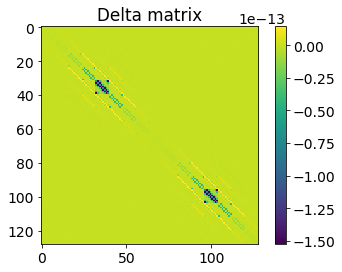

In [14]:
maxiter = 19
nit = 0;
while nit < maxiter:
    eigvals,eigvecs = la.eigh(H)
    #Take positive eigenvals and corresponding eigenvecs
    Umat = eigvecs[:N,:] #first N rows
    Vmat = eigvecs[N:,:] #last N rows
    #plt.figure();
    #plt.imshow(eigvecs)
    
    n_up = Make_Nup(eigvals,Umat);
    n_dn = Make_Ndn(eigvals,Vmat);
    n_new = n_up + n_dn;
    print(f'iter {nit} \t lowest energy = {eigvals[0]}')
    sigma_new = n_up - n_dn; 
    Delta_full = Make_Delta_ij(Vd,eigvals,Umat,Vmat,beta);
    Delta_new = np.zeros((N,N),dtype=float)
    Delta_new[ilist,jlist] = Delta_full[ilist,jlist]
    
    change = la.norm(n_new-n),la.norm(sigma_new-sigma)
    
    if np.max(change) < 1e-3:
        break
    else:
        Delta = Delta_new
        n = n_new;
        #print(n)
        sigma = sigma_new
        H = Build_H(Delta,n,sigma) 
    
    nit +=1


if nit >= maxiter:
    print('no convergence')
else:
    print(f'converged after {nit} iterations')



#Hamiltonian
H = Build_H(Delta,n,sigma) 
eigvals,eigvecs = la.eigh(H)
#Take positive eigenvals and corresponding eigenvecs
Umat = eigvecs[:N,:] #first N rows
Vmat = eigvecs[N:,:] #last N rows
#plt.figure();
#plt.imshow(eigvecs)

n_up = Make_Nup(eigvals,Umat);
n_dn = Make_Ndn(eigvals,Vmat);
n = n_up + n_dn;
print(f'iter {nit} \t lowest energy = {eigvals[0]}')
sigma = n_up - n_dn; 
Delta = Make_Delta_ij(Vd,eigvals,Umat,Vmat,beta);

plt.figure();
plt.imshow(Delta);
plt.title('Delta matrix');plt.colorbar()

print(f'<n> = {np.mean(n)}')
print(f'<sigma> = {sigma}')

#plt.figure();
#plt.imshow(H);plt.colorbar()
#plt.title("Hamiltonian")

#Diagonalize
#eigvals,eigvecs = la.eigh(H)
#print(f"energies: {eigvals}")

#plt.figure();
#plt.imshow(eigvecs);plt.colorbar()
#plt.title('eigenvectors')


Text(0, 0.5, 'x')

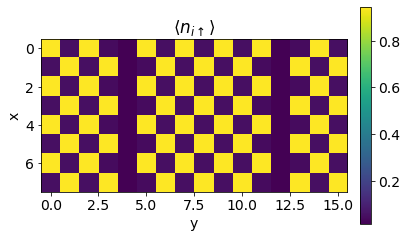

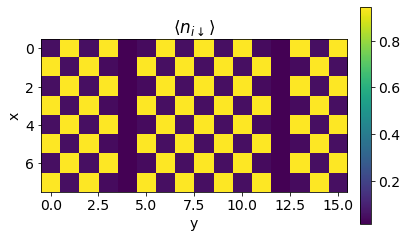

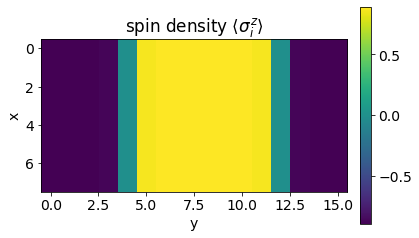

In [15]:
up_occ = np.zeros((Nx,Ny),dtype=float)
down_occ = np.zeros((Nx,Ny),dtype=float)
sigma_2d = np.zeros((Nx,Ny),dtype=float)

for ntotal in range(N):
    x = ntotal % Nx;
    y = ntotal // Nx;
    up_occ[x,y] = n_up[ntotal]
    down_occ[x,y] = n_dn[ntotal]
    sigma_2d[x,y] = sigma_new[ntotal] *(-1)**(x+y+1)

plt.figure();plt.imshow(up_occ);
plt.colorbar(fraction=0.046, pad=0.04);
plt.title(r'$\langle n_{i\uparrow}\rangle$')
plt.xlabel('y')
plt.ylabel('x')
plt.figure();plt.imshow(down_occ);
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r'$\langle n_{i\downarrow}\rangle$')
plt.xlabel('y')
plt.ylabel('x')
plt.figure();plt.imshow(sigma_2d);
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r'spin density $\langle \sigma_i^z\rangle$');
plt.xlabel('y')
plt.ylabel('x')

The iteration procedure seems to be indifferent w.r.t. particle/hole symmetry, but the energy shows that 7/8 filling is more energetically favorable. Result strongly depends on spin initialization, since it seeds how stripes are distributed. This iteration procedure is susceptable to falling into local minima, hence the initialization dependence. Also did not enforce filling level, just let things run and see where they end up

See notes.md for more information